In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from DomainPrediction import BaseProtein
from DomainPrediction.protein.base import FoldedProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools
from DomainPrediction.utils.tmalign import TMalign

In [4]:
root = '../..'
data_path = os.path.join(root, 'Data/')

In [5]:
## Read Protein
protein = BaseProtein(file=os.path.join(data_path, 'GxpS_ATC_AF.pdb'))
A = [i for i in range(33,522)] ## 34-522
C = [i for i in range(637,1067)] ## 638-1067
T = [i for i in range(538, 608)] ## 539-608

In [6]:
protein.get_residues(T) ## Get domains - Here T

'GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP'

In [ ]:
## Create fasta file with WT T domain
file = os.path.join(data_path, 'GxpS.T.fasta')
helper.create_fasta({'GxpS.T': protein.get_residues(T)}, file)

In [ ]:
## Create fasta file with WT 
file = os.path.join(data_path, 'GxpS.fasta')
helper.create_fasta({'GxpS': protein.sequence}, file)

In [ ]:
## Demo of reading fasta
file = os.path.join(data_path, 'GxpS.T.fasta')
sequences = helper.read_fasta(file, mode='str')

In [ ]:
sequences

In [ ]:
'''
    We had seq for ATC from esm3
    Extracting T from the sequences and creating new fasta file
'''
gen_fasta = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.fasta')
sequences = helper.read_fasta(gen_fasta)
seq_dict = {}
for rec in sequences:
    seq_dict[rec.id] = ''.join([str(rec.seq)[i] for i in T])

file = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.T.fasta')
helper.create_fasta(seq_dict, file)

In [7]:
## Compute Seq ID after aligning to WT
wt = os.path.join(data_path, 'GxpS.T.fasta')
gen = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.T.fasta')
pfam_T_hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
seq_ids = metrics.compute_sequence_identity(wt, gen, hmm=pfam_T_hmm)

100%|██████████| 1000/1000 [00:08<00:00, 118.86it/s]


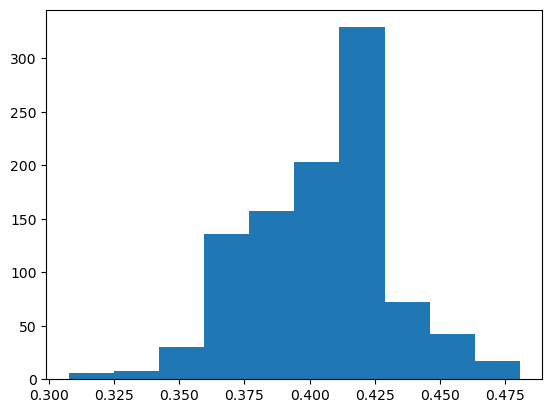

In [8]:
_ = plt.hist(seq_ids)

In [9]:
## % of sequences that contain the motif FF__GG_S
gen = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.T.fasta')
metrics.search_and_filter_motif(gen)

99.6% records contain motif


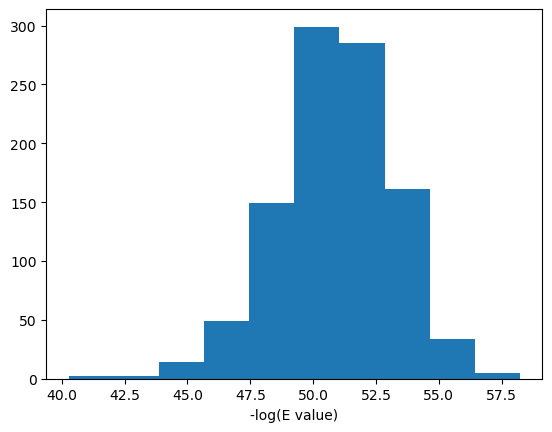

In [10]:
## Get dataframme from HMM search
hmmer = HmmerTools()

gen = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.T.fasta')
pfam_T_hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
df = hmmer.hmmsearch(hmm_path=pfam_T_hmm, fasta_file=gen)

_ = plt.hist(-np.log(df['Evalue']))
_ = plt.xlabel('-log(E value)')

In [11]:
## Compute TM scores and other metrics EsmFold Base
## Also save to meta data files
tm_path = '/nethome/kgeorge/workspace/DomainPrediction/src/DomainPrediction/utils/TMalign'
save_path = os.path.join(data_path, 'esm_experiments/gen_1000/pdbs_GxpS_ATC')
ref_structure = os.path.join(data_path, 'GxpS_ATC_EF.pdb')

TM_scores = metrics.compute_TMscore(tm_path, pdbs_path=save_path, ref_path=ref_structure, save_meta=True, prefix='EF_', force=False)

100%|██████████| 2000/2000 [1:49:10<00:00,  3.28s/it]  


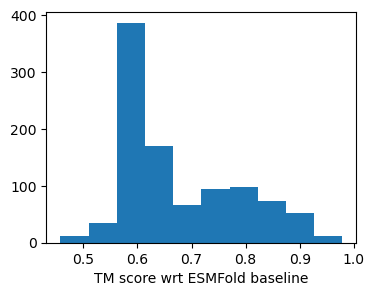

In [12]:
plt.figure(figsize=(4,3))
_ = plt.hist(TM_scores)
_ = plt.xlabel('TM score wrt ESMFold baseline')

In [15]:
## Compute TM scores and other metrics Alphafold Base
## Also save to meta data files
tm_path = '/nethome/kgeorge/workspace/DomainPrediction/src/DomainPrediction/utils/TMalign'
save_path = os.path.join(data_path, 'esm_experiments/gen_1000/pdbs_GxpS_ATC')
ref_structure = os.path.join(data_path, 'GxpS_ATC_AF.pdb')

TM_scores = metrics.compute_TMscore(tm_path, pdbs_path=save_path, ref_path=ref_structure, save_meta=True, prefix='AF_', force=True)

100%|██████████| 2000/2000 [1:35:48<00:00,  2.87s/it]  


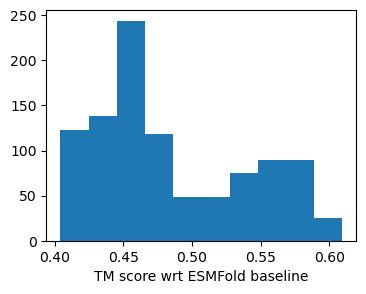

In [16]:
plt.figure(figsize=(4,3))
_ = plt.hist(TM_scores)
_ = plt.xlabel('TM score wrt ESMFold baseline')

#### Some Plots

In [7]:
save_path = os.path.join(data_path, 'esm_experiments/gen_1000/pdbs_GxpS_ATC')
file = os.path.join(save_path, 'GxpS_ATC-temp_0.5-gen_0.pdb')

In [8]:
fp = FoldedProtein(file)

In [9]:
folded_proteins = []
for f in tqdm(os.listdir(save_path)):
    file = os.path.join(save_path, f)
    if f.endswith('.pdb'):
        folded_proteins.append(FoldedProtein(file, id=f.replace('.pdb', '')))

100%|██████████| 2000/2000 [02:19<00:00, 14.36it/s]


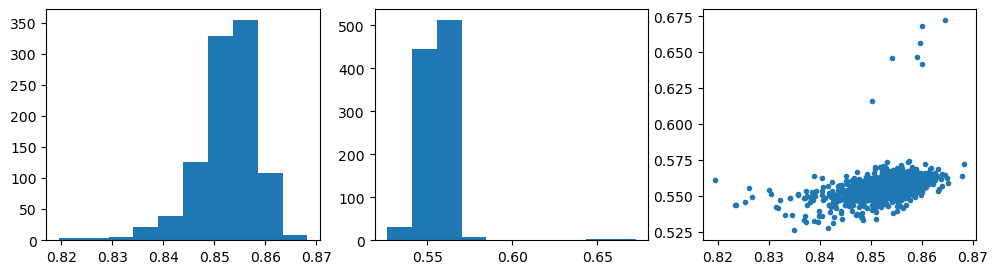

In [10]:
## pLDDT and pTM scores
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
_ = ax[0].hist([f.plddt for f in folded_proteins])
_ = ax[1].hist([f.pTM for f in folded_proteins])
_ = ax[2].scatter([f.plddt for f in folded_proteins], [f.pTM for f in folded_proteins], marker='.')

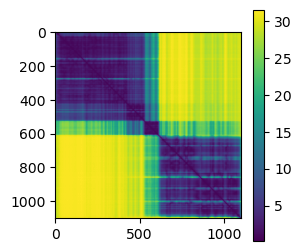

In [11]:
plt.figure(figsize=(3,3))
_ = plt.imshow(folded_proteins[0].pAE)
_ = plt.colorbar()

In [12]:
folded_proteins[5].metadata

{'predicted_aligned_error': array([[ 0.25011435,  1.7553849 ,  3.53404   , ..., 30.266487  ,
         30.365202  , 30.504929  ],
        [ 1.4325287 ,  0.2500083 ,  1.5221806 , ..., 30.023994  ,
         30.330027  , 30.464201  ],
        [ 2.9713156 ,  1.3579766 ,  0.25000048, ..., 30.313473  ,
         30.436481  , 30.696209  ],
        ...,
        [29.888165  , 29.859005  , 29.750788  , ...,  0.2500207 ,
          1.0514113 ,  2.2766845 ],
        [29.683746  , 29.57589   , 29.641207  , ...,  1.2336618 ,
          0.25004205,  1.1807127 ],
        [29.934307  , 29.918728  , 29.655245  , ...,  2.6431396 ,
          1.368228  ,  0.25050256]], dtype=float32),
 'ptm': array(0.55389166, dtype=float32),
 'tm_score': array(0.61847),
 'tm_rmsd': array(5.),
 'EFtm_rmsd': array(5.),
 'EFtm_seq_id': array(0.715),
 'EFtm_score': array(0.61847),
 'AF_tm_rmsd': array(5.87),
 'AF_tm_seq_id': array(0.647),
 'AF_tm_score': array(0.58388)}

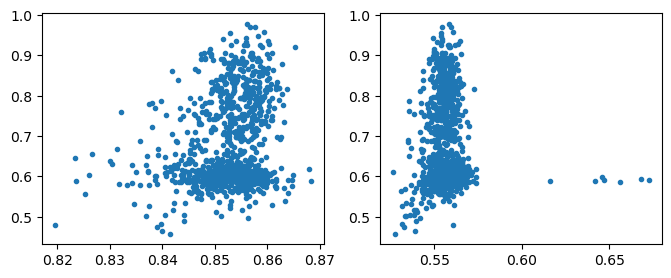

In [13]:
## pLDDT and pTM scores vs TM score
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
_ = ax[0].scatter([f.plddt for f in folded_proteins], [f.metadata['EFtm_score'] for f in folded_proteins], marker='.')
_ = ax[1].scatter([f.pTM for f in folded_proteins], [f.metadata['EFtm_score'] for f in folded_proteins], marker='.')

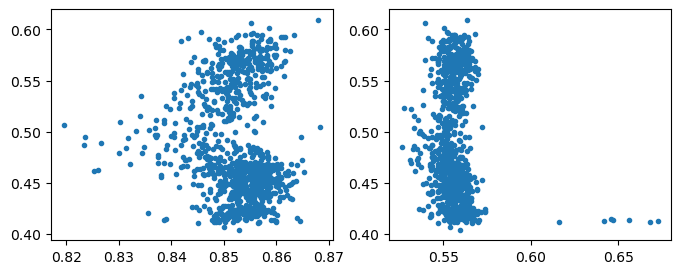

In [14]:
## pLDDT and pTM scores vs TM score
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
_ = ax[0].scatter([f.plddt for f in folded_proteins], [f.metadata['AF_tm_score'] for f in folded_proteins], marker='.')
_ = ax[1].scatter([f.pTM for f in folded_proteins], [f.metadata['AF_tm_score'] for f in folded_proteins], marker='.')

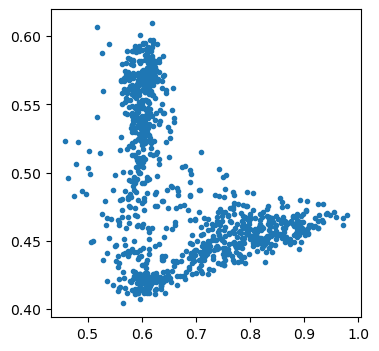

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
_ = ax.scatter([f.metadata['EFtm_score'] for f in folded_proteins], [f.metadata['AF_tm_score'] for f in folded_proteins], marker='.')

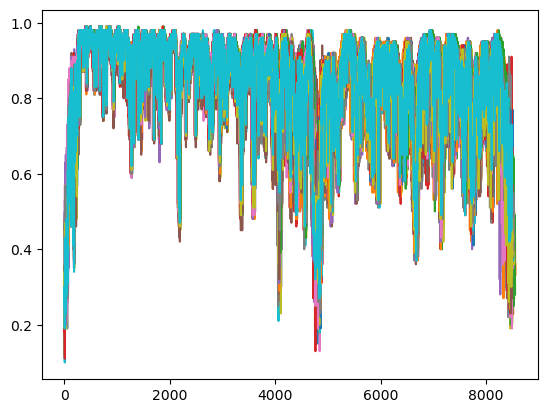

In [16]:
for i in range(100):
    plt.plot(folded_proteins[i].plddts)